# Global Budget Spending Analysis
----
<i> Project 1 Team 5 </i><br/> 
Brett Fuller, Diego Jones, Mav Sanchez

In [2]:
#Import necessary package dependencies
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

from pprint import pprint
from scipy.stats import linregress

#Import API Key
from config import *

#Define directories
source_data_dir = "source_data"
staging_data_dir = "staging_data"
target_data_dir = "target_data"
target_images_dir = "target_images"

### Functions declaration
----
#####            To be re-used for downstream cells

In [63]:
#Standardize country names
def get_country_name(isocode3):
    try:
        name = pycountry.countries.get(alpha_3=isocode3).name
        return name
    except:
        return None

# Plotters
def scatter_plotter(df, x='None', y='None'):
    try: 
        x_axis = df[x]
        y_axis = df[y]
        plt.title(f"{x} vs {y}")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.scatter(x_axis, y_axis, marker='o', facecolors="steelblue", edgecolors="black", alpha=0.75)
        plt.grid()
        plt.show()
        print('Plotting successful.')
    except:
        print('Plotting unsuccessful. Please review parameters and ensure correct column name is passed')


def linreg_plotter(df, x='None', y='None'):
    try: 
        # The plt clf will CLear out the Figure settings, for reusability
        plt.clf()
        x_values = df[x]
        y_values = df[y]

        # Calculation of linear regression given x and y values
        slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
        regression_values = x_values * slope + intercept
        line_eq = f"y = {round(slope, 2)}x + {round(intercept,2)}"
        print(f"The r-squared (absolute) is :{abs(rvalue)}\n")

        #Plot proper
        plt.scatter(x_values, y_values, facecolors="steelblue")
        plt.plot(x_values, regression_values, 'r-')
        plt.annotate(line_eq, (min(x_values)+5, min(y_values)+5), fontsize=15, color="red")

        plt.title(f"{x} vs {y}")
        plt.xlabel(x)
        plt.ylabel(y)
        #plt.savefig(f"output_data/LinReg_Latitude_Vs_{factor}_{where.title()}.png")
        plt.show()
        print('Plotting successful.')
    except:
        print('Plotting unsuccessful. Please review parameters and ensure correct column name is passed')
        
def call_worldbank(indicator_wb, years_wb):
    try:
        #World Bank
        api_format_wb = "json"

        # Get the list of Government expenditure on education, total (% of GDP)
        response = requests.get(f"{base_url_worldbank}{indicator_wb}?format={api_format_wb}&date={years_wb}").json()
        observation_size = response[0]['total']
        
        wb_response = requests.get(f"{base_url_worldbank}{indicator_wb}?format={api_format_wb}&date={years_wb}&per_page={observation_size}").json()
        wb_data_df = pd.DataFrame(wb_response[1])
        return wb_data_df
    except:
        print('API Call to WOrldBank failed')
        
        

### Data extraction
----
#####            API Calls

In [44]:
# Define base URLs for API
base_url_un ="put main endpoint here"
base_url_oecd ="http://stats.oecd.org/restsdmx/sdmx.ashx/GetDataStructure/SNA_TABLE11_SNA93"
base_url_worldbank = "http://api.worldbank.org/v2/country/all/indicator/"


In [67]:
wb_data_df_ps.columns

Index(['indicator', 'country', 'countryiso3code', 'date', 'value', 'unit',
       'obs_status', 'decimal'],
      dtype='object')

In [78]:
# Get the list of Government expenditure on education, total (% of GDP)
wb_data_df = call_worldbank("SE.XPD.TOTL.GD.ZS", "2000:2019") # Government expenditure on education, total (% of GDP)

wb_data_df.drop(columns=['indicator', 'country', 'unit', 'obs_status', 'decimal'], axis=1, inplace=True)
wb_data_df.rename(columns={'countryiso3code':'Country','date':'Year', 'value': 'Percent GDP Spent'}, inplace=True)
wb_data_df.Year = wb_data_df.Year.astype('int64')
wb_data_df['Country'] = wb_data_df['Country'].apply(lambda x: get_country_name(x))
wb_data_df.dropna(inplace=True)


# Get the list of Government expenditure on education, total (% of GDP)

wb_data_per_student_df = call_worldbank("SE.XPD.PRIM.PC.ZS", "2000:2019") # GDP Capita Per Student
wb_data_per_student_df.drop(columns=['indicator', 'country', 'unit', 'obs_status', 'decimal'], axis=1, inplace=True)
wb_data_per_student_df.rename(columns={'countryiso3code':'Country','date':'Year', 'value': 'Per Student Spending'}, inplace=True)
wb_data_per_student_df.Year = wb_data_per_student_df.Year.astype('int64')
wb_data_per_student_df['Country'] = wb_data_per_student_df['Country'].apply(lambda x: get_country_name(x))
wb_data_per_student_df.dropna(inplace=True)

In [79]:
wb_data_df.head()

,Country,Year,Percent GDP Spent
942,Afghanistan,2017,4.05887
943,Afghanistan,2016,4.22836
944,Afghanistan,2015,3.25580
945,Afghanistan,2014,3.69522
946,Afghanistan,2013,3.45446


In [ ]:
# Save df to csv so we don't have to perform API calls again
#staging_df.to_csv(f"{staging_data_dir}/staging_df.csv")

In [81]:
wb_data_per_student_df.head()

,Country,Year,Per Student Spending
942,Afghanistan,2017,10.02208
944,Afghanistan,2015,8.32950
945,Afghanistan,2014,9.65715
946,Afghanistan,2013,9.25884
947,Afghanistan,2012,7.34472


#####            CSV Load

In [7]:
# Load raw CSV files to data frame
pisa_science = pd.read_csv(f"{source_data_dir}/pisa_science_2006_2015.csv")
pisa_math = pd.read_csv(f"{source_data_dir}/pisa_math_2003_2015.csv")
pisa_reading  = pd.read_csv(f"{source_data_dir}/pisa_read_2000_2015.csv")

### Data cleansing
----

In [47]:
# Only pull data older than 2006
pisa_reading = pisa_reading.loc[pisa_reading['TIME']>=2006,['LOCATION','INDICATOR', 'TIME','Value'] ]
pisa_math = pisa_math.loc[pisa_math['TIME']>=2006,['LOCATION','INDICATOR', 'TIME','Value']]
pisa_science = pisa_science.loc[pisa_science['TIME']>=2006,['LOCATION','INDICATOR', 'TIME','Value']]

#Merge all Reading, Math, Science data
pisa_merged = pisa_reading.merge(pisa_math, how="inner", on=['LOCATION', 'TIME'], suffixes=('_READING', '_MATH'))
pisa_merged = pisa_merged.merge(pisa_science, how="inner", on=['LOCATION', 'TIME'], suffixes=('','_SCIENCE'))
pisa_merged = pisa_merged[['LOCATION','TIME', 'Value_READING','Value_MATH', 'Value']]

# Rename columns
pisa_merged = pisa_merged.rename(columns={'LOCATION' : 'Country','TIME': 'Year', 'Value_READING':'Reading','Value_MATH':'Math', 'Value':'Science'})
pisa_merged['Average Students Score'] = pisa_merged[['Reading','Math','Science']].mean(axis=1).round(2)

# Transform ISO3 codes countries to their corresponding pycountry name
pisa_merged['Country'] = pisa_merged['Country'].apply(lambda x: get_country_name(x))
pisa_merged.dropna()
pisa_merged.head()

,Country,Year,Reading,Math,Science,Average Students Score
0,Australia,2006,513,520,527,520.00
1,Australia,2009,515,514,527,518.67
2,Australia,2012,512,504,521,512.33
3,Australia,2015,503,494,510,502.33
4,Austria,2006,490,505,511,502.00


### Data analysis
----

#### Question 2: What is the education budget allocation effect on students' academic performance?
Data sources: OECD PISA Result<br/>
OECD Government budget allocation<br/>

In [82]:
# Merge PISA data and WorldBank data
wb_pisa_merged_df = pisa_merged.merge(wb_data_df, how="inner", on=['Country', 'Year'])
wb_pisa_merged_df.head()

,Country,Year,Reading,Math,Science,Average Students Score,Percent GDP Spent
0,Australia,2006,513,520,527,520.00,4.75359
1,Australia,2009,515,514,527,518.67,5.09327
2,Australia,2012,512,504,521,512.33,4.87765
3,Australia,2015,503,494,510,502.33,5.32175
4,Austria,2006,490,505,511,502.00,5.22652


---
#### The plot below shows a positive correlation between countries' expenditure on education on all levels and the students' performance on OECD Programme for International Student Assessment. The r-value between the correlation is 0.24. Countries with higher GDP expense allocated to education tends to score higher on Reading, Math, and Science. With the data set pulled from United Nations and World bank ranging from 2000 to 2019, it can be said that there is a causal relationship between education spending and students' performance.
---

The r-squared (absolute) is :0.2362212780270634



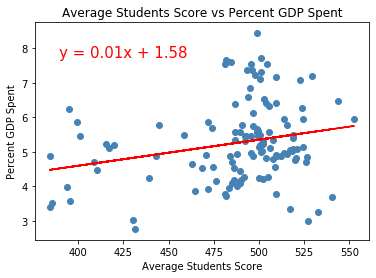

Plotting successful.


In [51]:
linreg_plotter(wb_pisa_merged_df, 'Average Students Score', 'Percent GDP Spent')

In [83]:
# Merge PISA data and WorldBank data
wb_pisa_ps_merged_df = pisa_merged.merge(wb_data_per_student_df, how="inner", on=['Country', 'Year'])
wb_pisa_ps_merged_df.head()

,Country,Year,Reading,Math,Science,Average Students Score,Per Student Spending
0,Australia,2006,513,520,527,520.00,17.74496
1,Australia,2009,515,514,527,518.67,19.94908
2,Australia,2012,512,504,521,512.33,18.17317
3,Australia,2015,503,494,510,502.33,18.81944
4,Austria,2006,490,505,511,502.00,22.58595


---
#### Although national GDP varies country to country and depends on economic standings, we pulled the GDP Per Capita (GDP % Population) and also saw a positive correlation between the mean students' score and GDP Per Student spending. Note that the OECD Data of "per student spending" is the 'average general government expenditure (current, capital, and transfers) per student in the given level of education, expressed as a percentage of GDP per capita.'. 
---

The r-squared (absolute) is :0.3672940012232876



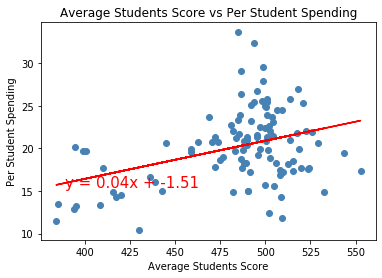

Plotting successful.


In [84]:
linreg_plotter(wb_pisa_ps_merged_df, 'Average Students Score', 'Per Student Spending')

In [ ]:
linreg_plotter(wb_pisa_ps_merged_df, 'Average Students Score', 'Per Student Spending')

In [86]:
wb_pisa_ps_merged_dfcorr = wb_pisa_ps_merged_df.corr()
wb_pisa_ps_merged_dfcorr.unstack().sort_values()

Year                    Science                  -0.091197
Science                 Year                     -0.091197
Year                    Math                     -0.078405
Math                    Year                     -0.078405
Year                    Per Student Spending     -0.065110
Per Student Spending    Year                     -0.065110
Year                    Average Students Score   -0.057935
Average Students Score  Year                     -0.057935
Year                    Reading                   0.008804
Reading                 Year                      0.008804
Per Student Spending    Reading                   0.338799
Reading                 Per Student Spending      0.338799
Per Student Spending    Science                   0.356253
Science                 Per Student Spending      0.356253
Average Students Score  Per Student Spending      0.367294
Per Student Spending    Average Students Score    0.367294
Math                    Per Student Spending      0.3840